# Ordinary Differential Equations (ODEs) - Initial Value Problems (IVPs)

In [9]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Initial value problems (IVPs)

Before we start, let's define some useful notation. The class of problems we try to solve using Simwork is a subet of the ODEs problems where we want to solve for a quantity with the knowledge of its time derivative and its initial condition. These problems are called Initial Value Problems (IVPs) and have been extensively studied for at least the past two and a half centuries. They have the following form:

\begin{equation}
\dot{y} = f(y,t), \quad y(t_0) = y_0
\end{equation}

where $y, y_0 \in \mathbb R^M$. Here $M$ corresponds to the **dimension** of the problem or, in other words, the number of unknowns. In our world, $M$ usually corresponds to the number of entities (or `Species` in Simwork).
$M$ can range from 1 to 500+ for very complex models. As a rule of thumb, the higher the $M$, the more difficult it is to solve the problem, but we'll come back to that later.

Other well-known types of ODEs are the Boundary Value Problems (BVPs) but this topic is beyond the scope of the present notebook.


## Numerical methods to solve IVPs

### Generalities

Among the vast collection of methods used to solve IVPs problems, we shall focus here on the implicit Backward Differentiation Formula (BDF) family because it's one of the methods (and actually almost the only one) we use in practice. It has proved to be very robust and efficient when solving large and _stiff_ problems (we'll try to define _stiffness_ in the next section).

### The fixed-order fixed-timestep BDF scheme

To solve (1), we perform the following discretization, where $t_n$ is the $n$-th discrete time point,

\begin{align}
y(t_n) &\simeq y_n, \nonumber\\
\dot{y}(t_n) = f(y(t_n), t_n) &\simeq f(y_n, t_n).
\end{align}


There are two independent ways to approximate the derivative $\dot{y}(t_n)$.

**One**, as shown in the eq. (2), $\dot{y}(t_n)$ is approximated by the function of discrete functional value at the time $t_n$, which is explicitly independent on history (does not involve terms $y_m, m < n$). 

**Two**, the derivative $\dot{y}(t_n)$ can be approximated using the values of the previous time steps $t_{n-1}, t_{n-2}, \ldots, t_{n-p}$. Function $y(t)$ is interpolated by a polynomial and numerical derivative is computed, which yields the following expression

\begin{equation}
\dot y(t_n) \simeq \frac{1}{h\beta} \sum_{i=0}^{p} \alpha_i y_{n-i},
\end{equation}

where $h$ is the current **time-step** (or step-size) $h = t_n - t_{n-1}$, $\{\alpha_i\}$ are interpolating coefficients, and $\beta$ is a normalization factor. $p$ is the **order** of the method. 
The $p$-th order BDF scheme is usually referred to as BDF-p. 
In practice, only the methods from BDF-1 (a.k.a _implicit Euler_) to BDF-6 (BDF-6 is so unstable that the library we're using stops at BDF-5) are used, the higher order methods being too unstable.

Combining (2) and (3), to relate the function discretization with its temporal expansion

\begin{equation}
 \sum_{i=0}^{p} \alpha_i y_{n-i} \simeq h\beta f(y_n, t_n)
\end{equation}

The approximation of the derivative $\dot{y}(t_n)$ in (3) depends on the current unknown step $y_n$ and on the previously solved steps $y_{m}, m<n$, that is, for the order $p$, the approximation depends on steps $y_{n}, \ldots, y_{n-p}$. 
That is why the BDF schemes are called **multi-step methods** (as opposed to one-step methods such as the Runga-Kutta methods, but that's beyond the scope of this notebook).

We also notice that in (2) the approximation $f(y(t_n), t_n)\simeq f(y_n, t_n)$ involves the current step to be solved, $y_n$. 
We say that the method is **implicit** (as opposed to explicit methods for which the approximation only involves previously solved steps). 
As a rule of thumb, implicit methods are more _robust_ or _stable_ than explicit ones but they are also more computationally expensive, we'll see why in the next section.

### Numerical solution of an IVP using a fixed order BDF-scheme

#### Time iterations

Let's see how we would solve the IVP problem stated in (1) with a BDF-$p$ scheme. 
For the sake of notation clarity, we consider the case where $p \ge 2$ in the following. 
We first assume we know the initial condition $y_0$ and also the $p-1$ subsequent steps $y_1, \ldots, y_{p-1}$ (which means in practice we cannot really use any BDF$-p_{p\ge 2}$ method _from the beginning_).

Then, for any time step $t_n$, $n \ge p$, we find for the current unknown $y_n$ by solving the following equation:

\begin{align}
R(y_n) := \alpha_0 y_n + \sum_{i=1}^{p}\alpha_i y_{n-i} - h \beta f(y_n, t_n) &= 0 \\
h\beta f(y_n, t_n) - \alpha_0 y_n&= \sum_{i=1}^p \alpha_i y_{n-i}. \nonumber
\end{align}


Equation (5) is usually referred to as the _time iteration equation_, meaning we have to solve it for each time-step of our time integration. 
We solve (5) for the first unknown $y_n, n=p$ with the knowledge of $y_0, \ldots y_{p-1}$, then we solve for $y_{p+1}$ with the knowledge of $y_1, \ldots, y_{p}$ and so on until we reach a final user-defined time $t_n = T_{max}$.

Of course, the previous values $y_{n-1}, \ldots, y_{n-p}$ have already been solved for in the previous steps, therefore the only unknown in (5) is $y_n$. Remember however that $y_n \in \mathbb R^M$ so there are $M$ unknowns for each time step.

Can we solve (5) analytically? 
Unfortunately, the answer is **no**, because $f(y_n, t_n)$ is an arbitrary function and $y_n$ is the unknown so, in most cases, there is no closed form solution for (5).
We'll have to use a root-finding algorithm to cancel out $R(y_n)$.
It's the curse of every **implicit** method and that's why they are generally more expensive than explicit ones.

#### Yet another iteration (yai !)

For each time iteration step $n$, we're going to solve (5) using another iterative method (which has nothing to do with the time iteration). 
There exist many methods to do what we want but we'll focus here on the [Newton-Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method) because it's very efficient and above all because that's the one we use in practice.

Given an initial guess for $y_n$ called $y_{n,0}$, (5) is solved following this simple algorithm (in pseudo-code below). 
The initial guess is usually an estimator $\hat y_{n}$ computed with an explicit scheme, but each solver has its own collection of heuristics. 
It may not seem much but the right choice for the initial guess is paramount and conditions the success of the root-finding procedure.

```python
# Newton-Raphson iterations
for k in {1..K}
  yk        := y(n, k)
  if (R(yk) < tol) then break else continue
  x         := solve {J(yk)*x = -R(yk)}                                      # (6)
  y(n, k+1) := yk + x
```

In the following illustration, we use lower indices to denote vector indices, 
that is $y_l$ is the $l$-th element of vector $y$, $R_k$ is the $k$-th element of the vector $R\in \mathbb R^M$. 
Here, $J(R(y))$ is called the Jacobian of $R$ (or the Jacobian matrix $J_{k,l}$) and is defined:

$$
J_{k,l}(R(y)) = \frac{\partial R_k(y)}{\partial y_l} \in \mathbb R^{M\times M}.
$$

Knowing the analytical form of $J(R(y_n))$ (see eq. (5)), then we can iteratively solve 

$$
y_{n,q+1} = y_{n,q} - J_{k,l}^{-1} R(y_{n,q}) \tag{6},
$$

until the process converges to $y_n: R(y_{n})=0 \in \mathbb R^M$.

Solving the linear system in (6) is very costly and, in most applications, constitutes the bottleneck in terms of computational time. 
If the matrix is dense and if we use a direct linear solver, the time complexity is $\mathcal O (M^3)$, **cubic in the number of unknowns!**  
Try to remember that every time you want to add an unknown to your problem.

_Remark: To be fair, it is not always true that we use a direct solver. If the matrix is sparse enough it can be interesting to use an iterative solver which has cost $\mathcal{O}(k M^2)$ but that's another topic entirely._

To summarize, the most important cost is the solving of (6) which, _for every time-step_, is repeated $K$ times. $K$ is the number of iterations needed for the Newton algorithm to converge and is of the order of 5-10 typically.

### Accuracy - stability

The higher the order, the more accurate the method is. Indeed, it can be shown that the truncation error for the $p$-order method is $\mathcal O (h^p)$, meaning bigger time steps can be taken to reach a given accuracy. Which means less computational time, that's very interesting!
Unfortunately, higher order also means more instability. Unfortunately, for $p = 3, 4, 5$, the methods are usually unusable in practice _as is_. That's where adaptive order BDF come into action.

### Adaptive order (and adaptive time-step) BDF

In practice we use all BDFs (BDF-1 -> BDF-5) at once!
This hybrid scheme is called adaptive order because it allows for a dynamic adaptation
of the order of the method during the time integration based on stability detection
and the accuracy control.
The time-step itself is also adaptive, also for stability and accuracy.
For this reason, the formula in (5) does not hold anymore but the principle stays the same: the derivative of $y$ is approximated using the current step and $p$ previous steps.  
In layman's terms: at a given time, the solver chooses a combination of the highest possible order and the highest possible timestep that is _stable_ (the solver has tools to assess the current stability) and that respects the (user-defined) accuracy threshold (the solver can also estimate the approximation error).

Programming a smart adaptive-order adaptive-timestep BDF solver is very difficult. For this reason, we use an external tool written in C++ called [CVODE](https://computation.llnl.gov/projects/sundials/cvode) (from the [Sundials suite](https://computation.llnl.gov/projects/sundials)). The job of Simwork is to translate the user-defined network of reactions into an IVP that will be solved by the Sundials solver. We let the external tool do all the hard work but we can however alleviate its burden by choosing educated tolerance parameters and scalings for the variables (that is your job and we'll introduce some good practices in the following Simwork tutorial).

## Numerical Illustration

Let's illustrate the previous considerations with a simple model, the Robertson model. We'll see later how we deal with this model in Simwork but right now, for the sake of simplicity, we'll use a Python library to do the job.
Here is the model in chemical notation:

\begin{align*}
A &\xrightarrow{k1} B \\
B + B &\xrightarrow{k2} B + C \\
B + C &\xrightarrow{k3} A + C
\end{align*}

These reactions translate into the following ODE notation (as per the rules explained on p.4 (264) of this [book](https://link.springer.com/content/pdf/10.1007/978-0-387-09680-3_18.pdf) for instance):

\begin{align*}
\frac{dA}{dt} &= -k_1 A + k_3 BC \\
\frac{dB}{dt} &= k_1 A - k_3 BC - k_2 B^2 \\
\frac{dC}{dt} &= k_2 B^2 \\
&A(t=0) = 1, \quad B(t=0) = 0, \quad C(t=0) = 0
\end{align*}

where $k_1 = 4.10^{-2}, \quad k_2 = 3.10^7, \quad k_3 = 10^4$.

We notice that three different rates _scales_ coexist in this model: a fast reaction (B+C->A+C), a "very" fast reaction (B+B->B+C) and a slow one (A->B).
This coexistence of different time scales makes the model "stiff" and therefore hard to solve, especially with **explicit** solvers.  
In fact, "stiff" IVPs are sometimes defined as "not solvable by explicit solvers". The definition of stiffness is not consensual and some definitions are rather technical so this one has the merit of being easily understandable.


In [10]:
# Let's import some useful modules
%matplotlib inline
from matplotlib import pyplot
import numpy as np
from scipy.integrate import solve_ivp

### Solving the Robertson model with an Explicit solver

Let us solve the previous IVP with an explicit solver, namely 'RKF45', an explicit [Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) scheme.
Run the cell below using the "Run" button (or alternatively `Shift + Enter`). After the model is solved, a plot of the solution should appear. What do you notice ?

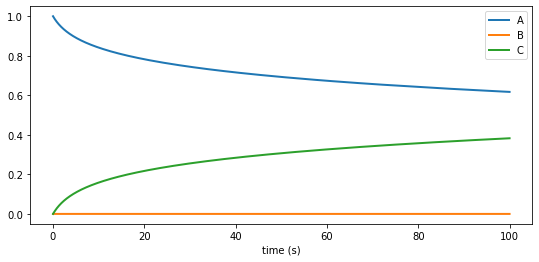

In [15]:
# Implementation of the Robertson model
def robertson(t, y): 
    k1 = 0.04
    k2 = 3e7
    k3 = 1e4
    ydot = [-k1*y[0] + k3*y[1]*y[2], k1*y[0] - k3*y[1]*y[2] - k2*y[1]**2, k2*y[1]**2]
    return ydot
sol = solve_ivp(robertson, [0, 100], [1, 0, 0], method='RK45', rtol=1e-7, atol=1e-7)

pyplot.figure(figsize=(9.0, 4.0))  # set the size of the figure
pyplot.xlabel("time (s)")
pyplot.plot(sol.t, sol.y[0], '-', color='C0', linewidth=2, label = "A");
pyplot.plot(sol.t, sol.y[1], '-', color='C1', linewidth=2, label = "B");
pyplot.plot(sol.t, sol.y[2], '-', color='C2', linewidth=2, label = "C");
pyplot.legend(loc="upper right");

### What takes so long?
You may have noticed that several seconds are necessary to solve a seemingly trivial IVP using an explicit solver. This is an illustration of the _stiffness_ we gave earlier. Actually, the solver does not fail _per se_ but takes an absurd amount of time to solve the problem.  
Try playing around with the `atol` and `rtol` options (more on that during the simwork tutorial). What do you observe?  
We can further confirm the stiffness diagnosis by looking at the number of internal time steps taken by the solver.
The plot below represents the number of _internal_ time steps taken by the solver across the simulation interval $[0, 100]$. 
In addition to the sheer amount of time steps (100k+), what should strike you is the fact that this number is increasing with the simulation time, even though the variables _seem_ to have reached some kind of equilibrium. Nothing happens and yet the solver is struggling to find a solution. That's a perfect illustration a _stiff_ IVP.

Total number of RHS evaluations:  812294


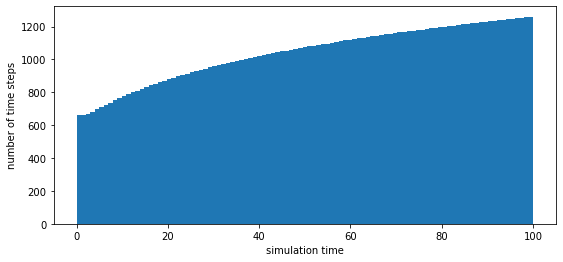

In [16]:
pyplot.figure(figsize=(9.0, 4.0))  # set the size of the figure
pyplot.hist(sol.t, bins=101);
pyplot.ylabel("number of time steps")
pyplot.xlabel("simulation time")
print("Total number of RHS evaluations: ", sol.nfev)


### Implicit BDF scheme
Figuring out that the IVP is _stiff_ makes us want to try an implicit solver. In fact, most of the problems you'll be dealing with in the future will be _stiff_ IVPs and this is why in practice we don't bother trying explicit solvers and start with implicit ones (and more precisely with `BDF`) right away.

Run the cell below which solves the same IVP but this time with the Python implementation of the implicit adaptive-order adaptive-timestep BDF. What do you notice ?

Total number of RHS evaluations:  123


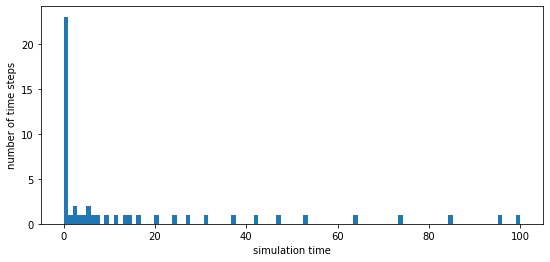

In [17]:
sol = solve_ivp(robertson, [0, 100], [1, 0, 0], method='BDF')
pyplot.figure(figsize=(9.0, 4.0))  # set the size of the figure
pyplot.hist(sol.t, bins=101)
pyplot.ylabel("number of time steps")
pyplot.xlabel("simulation time")
print("Total number of RHS evaluations: ", sol.nfev)

Pretty fast eh? And looking at the histogram of the internal time steps (only $\simeq$ 50 internal time steps by the way !), we notice that after the "shock" near $t=0$ (you'll see this shock in more details in the Simwork tutorial), the solver takes roughly a constant number of time steps across the simulation interval.

### To go further

[1] Süli E., Mayers D. (2003). _An Introduction to Numerical Analysis_. Cambridge University Press. [link](http://newdoc.nccu.edu.tw/teasyllabus/111648701013/Numerical_Analysis.pdf)

[2] Hairer E., Norset S.P. _et al_ (2008). _Solving Ordinary Differential Equations - I - Nonstiff Problems_. Springer. (ask me for the book)

[3] Hairer E., Norset S.P. _et al_ (2008). _Solving Ordinary Differential Equations - II - Stiff and Differential-Algebraic Problems_. Springer. (ask me for the book)

[4] User Documentation for Sundials CVODE v3.1.2 [link](https://computation.llnl.gov/sites/default/files/public/cv_guide.pdf)